In [1]:
import math
import numpy as np
#from sys import getsizeof
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import scipy.stats as st

In [2]:
# Constants
h_scale = .70
c = 2.99792458e5
w = -1
class shared:
    kind = 'cubic'
    n = 2000
    
    # Below is not to be confused with z_start and z_end, which are the first and
    #  last values of all of the redhshift values found in Brandenger calculations
    step   = .001               # Step value for an arbitary redshift array
    zbegin = .01               # Starting z value for creating a redshift array over an arbitrary range
    zfinal = 1.4         # Final z value in arbitrary redshift range
    n_interp = int((zfinal - zbegin) / step)        # How many values should be in interpolated arrays

In [3]:
class Brandenberger:
    """Calculates τ, t_c, h, a, z, and ℜ in the Brandenberger model"""
    
    a0 = 1.0               # Current scale factor value
    h0 = 17150             # h = H/H0 initial value
    #Ωm = .25              # Brandenberger dark matter density parameter; used in calculating shift parameter ℜ

    sec_to_yr = 3600.0 * 24.0 * 365.0            # Convert from seconds to years
    #H0 = 3.0856776e19 * 100.0 * h_scale * sec_to_yr
    
    #H0 = 2.268543540763823e-18 * sec_to_yr       # Hubble's constant [sec^-1] --> [years^-1]
    #H0 = 100 * h_scale * 3.2407792700054e-20 * sec_to_yr
    #τ0 = 379000 * H0                             # Dimensionless   start time: τ = H0 * t_c
    #τf = 1                                       # Dimensionless current time
    #stepB = τf / shared.n                               # Step size
    #τ     = np.arange(τ0, τf + τ0, stepB)        # Dimensionless time array
    
    def __init__(self, Ωm, hscale, E, t_cB, h_sol, a_solB, zB, ℜ, dLBspl, dLBinterp):
        self.Ωm        = Ωm
        self.hscale    = hscale
        self.E         = E 
        self.t_cB      = t_cB
        self.h_sol     = h_sol
        self.a_solB    = a_solB
        self.zB        = zB
        self.ℜ        = ℜ
        self.dLBspl    = dLBspl
        self.dLBinterp = dLBinterp
    
    def solve_h(self, h, t):
        """Differential equation that gives h(τ) as a solution"""
        return ((-3.0 / 2.0) * h**2.0 + (3.0 / 2.0) * np.cos(.5 * self.E * t)**2.0)
    
    def dL_Brandenberger(self):
        """Calculates the luminosity distance dL in the Brandenberger model. Returns a spline of dL and some interpolated values from the spline (used in plotting)"""
        
        def a_spl_Brandenberger(t_cB, a_solB, kind):
            """Splines cosmic time and scale factor; used in integral of dL"""
            a_splB  = interp1d(t_cB, a_solB, kind)                             # Spline of a with cosmic time
            return a_splB
        
        H0 = 100 * self.hscale * 3.2407792700054e-20 * self.sec_to_yr
        
        integrand   = lambda x : 1.0 / (a_splB(x))                             # Brandenberger luminosity distance integrand
        
        a_splB      = a_spl_Brandenberger(self.t_cB, self.a_solB, shared.kind) #Splines t_c. Used to integrate dL
        
        self.dLB    = [(1.0 + self.zB[i]) * H0 * integrate.quad(integrand, self.t_cB[i], self.t_cB[shared.n - 1])[0] for i in range(shared.n)]  # Integral of luminosity distance in Brandenberger
        
        self.dLBspl = interp1d(self.zB, self.dLB, shared.kind)                 # Spline of Brandenberger dL
        
        #Loop that grabs interpolated values of the luminsity distance. Used for plotting
        #for i in range(shared.n_interp):
        #    val = ((shared.zfinal - shared.zbegin) / shared.n_interp) * i      # redshift value at which to interpolate
        #    self.dLBinterp[i] = self.dLBspl(val)                               # Save interpolated value
            
        for i in range(shared.n):
            #val = self.zB[i]
            val = np.linspace(shared.zbegin, shared.zfinal, shared.n, endpoint = True)
            self.dLBinterp[i] = self.dLBspl(val[i])
        
        return self.dLBspl, self.dLBinterp
    
    def run_Brandenberger(self):
        """Calculates the essential parameters in the Brandenberger model"""
        
        def solve_a(a, t):
            """Differential equation for solving for a(t_c)"""
            return a * h_spl(t)
        
        def z_to_h(z):
            """Function that, given a redshift value, returns h; converts z to a and then interpolates h using a"""
            a = 1.0 / (1.0 + z)
            return a_h_spl(a)
        
        ℜ_int = lambda z : 1.0 / z_to_h(z)                               # Shift Parameter integrand
        
        
        H0 = 100 * self.hscale * 3.2407792700054e-20 * self.sec_to_yr
        
        τ0 = 379000 * H0                             # Dimensionless   start time: τ = H0 * t_c
        τf = 1                                       # Dimensionless current time
        stepB = τf / shared.n                               # Step size
        τ     = np.arange(τ0, τf + τ0, stepB)        # Dimensionless time array
        
        for i in range(shared.n): self.t_cB[i] = τ[i] / H0          # Cosmic time t_c = τ / H0
            
        t_bw  = np.flipud(self.t_cB)                                          # Backwards time array to solve for a backwards -> guarenteed a0 = 1

        h_integ = odeint(self.solve_h, self.h0, τ)[..., 0]               # Dimensionless Hubble parameter solved over τ
        self.h_sol  = h_integ * H0                                       # Convert h to H bc H = H0 * h; units -> [years^-1]

        h_spl = interp1d(self.t_cB, self.h_sol, shared.kind, fill_value = 'extrapolate')

        a_solbw = odeint(solve_a, self.a0, t_bw)[..., 0]                      # Solve for a
        self.a_solB = np.flipud(a_solbw)                                      # Flip scale factor back to correct direction
        
        #a_splB = a_spl_Brandenberger(self.t_cB, self.a_solB, shared.kind)
        #a_splB = interp1d(self.t_cB, self.a_solB, shared.kind)               # Spline of a with cosmic time

        for i in range(shared.n): self.zB[i] = (1.0 / self.a_solB[i]) - 1.0   # Solve for z from scale factor

        a_h_spl = interp1d(self.a_solB, self.h_sol, shared.kind)              # Spline of a and h, used for ℜ

        #z_r = self.zB[0]                                                      # Recombination redshift
        z_r = 1000
        self.ℜ  = np.sqrt(self.Ωm) * H0 * integrate.quad(ℜ_int, 0, z_r)[0]        # Integral to calculate the shift parameter, ℜ
        
        return self.h_sol, self.t_cB, self.a_solB, self.zB, self.ℜ

In [315]:
#inst[index_min_Bb].zB[0]

testb = Brandenberger(.3, .67, 1, t_cB = np.zeros(shared.n), h_sol = np.zeros(shared.n), a_solB = np.zeros(shared.n), zB = np.zeros(shared.n), ℜ = 1, dLBspl = ini_spl, dLBinterp = np.zeros(shared.n))
%time testb.run_Brandenberger()
%time testb.dL_Brandenberger()
print(testb.ℜ)


testb2 = Brandenberger(.3, .76, 1, t_cB = np.zeros(shared.n), h_sol = np.zeros(shared.n), a_solB = np.zeros(shared.n), zB = np.zeros(shared.n), ℜ = 1, dLBspl = ini_spl, dLBinterp = np.zeros(shared.n))
%time testb2.run_Brandenberger()
%time testb2.dL_Brandenberger()
print(testb2.ℜ)
'''errtest = math.sqrt(.034)
print(errtest)
print(3.0856776e-19 * 100.0 * h_scale*3.0856776e+19)
print(100 * h_scale * 3.2407792700054e-20)
print(2.268543540763823e-18 * 3.0856776e+19)

sec_to_yr = 3600.0 * 24.0 * 365.0            # Convert from seconds to years
H0 = 3.0856776e19 * 100.0 * h_scale# * sec_to_yr
print(H0)
H0 = 2.268543540763823e-18 * sec_to_yr       # Hubble's constant [sec^-1] --> [years^-1]
print(H0)
print(100 * h_scale * 3.2407792700054e-20 * sec_to_yr)'''

Wall time: 84.4 ms
Wall time: 3.19 s
1.8652894445769843
Wall time: 68.4 ms
Wall time: 3.37 s
1.8652894445767616


"errtest = math.sqrt(.034)\nprint(errtest)\nprint(3.0856776e-19 * 100.0 * h_scale*3.0856776e+19)\nprint(100 * h_scale * 3.2407792700054e-20)\nprint(2.268543540763823e-18 * 3.0856776e+19)\n\nsec_to_yr = 3600.0 * 24.0 * 365.0            # Convert from seconds to years\nH0 = 3.0856776e19 * 100.0 * h_scale# * sec_to_yr\nprint(H0)\nH0 = 2.268543540763823e-18 * sec_to_yr       # Hubble's constant [sec^-1] --> [years^-1]\nprint(H0)\nprint(100 * h_scale * 3.2407792700054e-20 * sec_to_yr)"

In [4]:
class ΛCDM:
    """Calulates z and dL in ΛCDM"""
    Ωb = 0                    # Baryonic    density parameter
    Ωm = .3                    # Dark matter density parameter
    Ωr = 0                     # Radiation   density parameter
    ΩΛ = 1.0 - Ωb - Ωm - Ωr    # Dark energy density parameter
    
    #Ωb = 0.046e0                 #Baryonic density parameter
    #Ωm = 0.224e0                 #Dark matter density parameter
    #Ωr = 8.3e-5                  #Radiation density parameter
    #ΩΛ = 1.0 - Ωb - Ωm - Ωr    # Dark energy density parameter
    
    z_start  = 1.401           # First redshift value from the Brandenberger model
    z_end    = .001               # Last redshift value from Brandenberger
    n  = 2000                 # Number of dL points for ΛCDM
    
    def __init__(self, zΛCDM, dLΛspl, dLEmpspl, dLVacspl, dLΛinterp, dLEmpinterp, dLVacinterp):
        self.zΛCDM = zΛCDM
        
        self.dLΛspl = dLΛspl
        self.dLEmpspl = dLEmpspl
        self.dLVacspl = dLVacspl
        
        self.dLΛinterp = dLΛinterp
        self.dLEmpinterp = dLEmpinterp
        self.dLVacinterp = dLVacinterp
        
    def get_H(self, x): return np.sqrt((self.Ωb + self.Ωm) * x**-3.0 + self.Ωr * x**-4.0 + self.ΩΛ * x**(-3.0 * (1.0 + w)))
    
    def dL_ΛCDM(self):
        
        integrandΛCDM = lambda x : 1.0 / (x**2.0 * self.get_H(x))    # Integrand for dL(z) = a0r(z)(1+z)
        
        dLΛCDM   = [(1.0 + self.zΛCDM[i]) * integrate.quad(integrandΛCDM, 1.0 / (1.0 + self.zΛCDM[i]), 1)[0] for i in range(shared.n)]   # Luminosity distance in ΛCDM; only DM and DE
        
        dLempty  = [(self.zΛCDM[i] + (self.zΛCDM[i]**2.0) / 2.0) for i in range(shared.n)]                                               # dL in empty universe; Ωk = 1
        dLvac    = [(self.zΛCDM[i] + self.zΛCDM[i]**2.0)         for i in range(shared.n)]                                               # dL in vacuum energy dominated universe; ΩΛ = 1
        
        # Create cubic splines of ΛCDM over redshift;
        #  used for interpolating dL over an arbitrary redshift
        self.dLΛspl   = interp1d(self.zΛCDM,  dLΛCDM, shared.kind)
        self.dLEmpspl = interp1d(self.zΛCDM, dLempty, shared.kind)
        self.dLVacspl = interp1d(self.zΛCDM,  dLvac, shared.kind)
        
        for i in range(shared.n):
            #val = ((shared.zfinal - shared.zbegin) / shared.n_interp) * i    # redshift value to be interpolated
            val = self.zΛCDM[i]
            
            self.dLΛinterp[i]   = self.dLΛspl(val)                                # Save interpolated value
            self.dLEmpinterp[i] = self.dLEmpspl(val)
            self.dLVacinterp[i] = self.dLVacspl(val)
        
        return self.dLΛspl, self.dLEmpspl, self.dLVacspl, self.dLΛinterp, self.dLEmpinterp, self.dLVacinterp
    
    def calc_zΛCDM(self):
        #val = ((shared.zfinal - shared.zbegin) / shared.n_interp) * i
        
        #self.zΛCDM = np.arange(shared.zbegin, shared.zfinal + shared.zbegin, shared.zfinal / shared.n)
        self.zΛCDM = np.linspace(shared.zbegin, shared.zfinal, shared.n, endpoint = True)
        
        #self.zΛCDM = [((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)]
        
        #stepΛCDM = (self.z_start - self.z_end) / self.n            # Redshift range for ΛCDM that stops where Brandenberger z stops
        
        #for i in range(self.n): 
        #self.zΛCDM = np.arange(self.z_end, self.z_start, stepΛCDM) # Redshift in ΛCDM
        
        return self.zΛCDM
    

In [5]:
ΔE_low  = 0#1e-11#.03                                        # Lowest bound of the dimensionless energy parameter
ΔE_high = 2#1e-10#.77                                        # Upper bound of energy parameter
n_ΔE    = 1                                          # Number of E values we want; it will end up being 1 MORE than this
step_ΔE = (ΔE_high - ΔE_low) / n_ΔE                  # Step to find intermediare E values

ΔE = np.linspace(ΔE_low, ΔE_high, n_ΔE + 1, endpoint = True)

#ΔE = np.arange(ΔE_low, ΔE_high + ΔE_low, step_ΔE)    # Filled E array
print('ΔE :', ΔE)

inst = np.ndarray((n_ΔE + 1,), dtype = np.object)    # Create an array that will hold the objects which each have a different E value
Ωm = [.25, .25, .25]
hscale = [.67, .67, .67]

smplx = [1, 2, 3, 4]
smply = [1, 2, 3, 4]
ini_spl = interp1d(smplx, smply, kind = shared.kind)

# Each iteration of this loop initializes each object with the Brandenberger class.
#  Then is runs to calculates t, h, a, z, ℜ, dL interpolated, and dL spline for each E
for i in range(n_ΔE + 1):
    #print('ΔE[%s] = %.3f, time:' % (i, ΔE[i]))
    print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    inst[i] = Brandenberger(Ωm[i], hscale[i], ΔE[i], t_cB = np.zeros(shared.n), h_sol = np.zeros(shared.n), a_solB = np.zeros(shared.n), zB = np.zeros(shared.n), ℜ = 1, dLBspl = ini_spl, dLBinterp = np.zeros(shared.n))
    #%time inst[i].run_Brandenberger()
    #%time inst[i].dL_Brandenberger()                 # Returns both dL interpolated and dL spline
    inst[i].run_Brandenberger()
    inst[i].dL_Brandenberger()                 # Returns both dL interpolated and dL spline
    #print(' ')
    #print('size of inst[', i, ']:', getsizeof(inst[i].E) + getsizeof(inst[i].t_cB) + getsizeof(inst[i].h_sol) + getsizeof(inst[i].a_solB) + getsizeof(inst[i].a_splB) + getsizeof(inst[i].zB))
    
print(' -- done with all instances of ΔE -- ')

ΔE : [0. 2.]
ΔE[0] = 0.000
ΔE[1] = 2.000
 -- done with all instances of ΔE -- 


In [6]:
#heatΩmE = np.arange((n_ΔE + 1) * len(Ωm)).reshape((n_ΔE+ 1), len(Ωm)) * 0
n_ΔE    = 29#10
lowE = .01
highE = 2
ΔE = np.linspace(lowE, highE, n_ΔE + 1, endpoint = True)
print(ΔE)
Ωmlow = .235#0.232
Ωmhigh = .283#0.285
nΩm = 100#10
Ωm = np.linspace(Ωmlow, Ωmhigh, nΩm, endpoint = True)
print(Ωm)

nH0 = 2
H0low = .65
H0high = .77
hscale = [.7]
#hscale = np.linspace(H0low, H0high, nH0, endpoint = True)
print(hscale)

#heatΩmE = np.ndarray(((n_ΔE + 1), len(Ωm),), dtype = np.object)
heatΩmE = np.ndarray(((n_ΔE + 1), len(Ωm), len(hscale),), dtype = np.object)
#heatΩmE = np.ndarray(((n_ΔE + 1), len(Ωm),), dtype = np.object)

for i in range(n_ΔE + 1):
    print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    for j in range(len(Ωm)):
        #print('|-->Ωm[%s] = %.3f' % (j, Ωm[j]))
        for k in range(len(hscale)):
            #print('|######>h[%s] = %.3f' % (k, hscale[k]))
            heatΩmE[i][j][k] = Brandenberger(Ωm[j], hscale[k], ΔE[i], t_cB = np.zeros(shared.n), h_sol = np.zeros(shared.n), a_solB = np.zeros(shared.n), zB = np.zeros(shared.n), ℜ = 1, dLBspl = ini_spl, dLBinterp = np.zeros(shared.n))
            heatΩmE[i][j][k].run_Brandenberger()
            # DO NOT USE THIS LINE!!! #heatΩmE[i][j][k].dL_Brandenberger()
    print('--------------------')
#print(heatΩmE)
print(' -- done with heat map -- ')

[0.01       0.07862069 0.14724138 0.21586207 0.28448276 0.35310345
 0.42172414 0.49034483 0.55896552 0.62758621 0.6962069  0.76482759
 0.83344828 0.90206897 0.97068966 1.03931034 1.10793103 1.17655172
 1.24517241 1.3137931  1.38241379 1.45103448 1.51965517 1.58827586
 1.65689655 1.72551724 1.79413793 1.86275862 1.93137931 2.        ]
[0.235      0.23548485 0.2359697  0.23645455 0.23693939 0.23742424
 0.23790909 0.23839394 0.23887879 0.23936364 0.23984848 0.24033333
 0.24081818 0.24130303 0.24178788 0.24227273 0.24275758 0.24324242
 0.24372727 0.24421212 0.24469697 0.24518182 0.24566667 0.24615152
 0.24663636 0.24712121 0.24760606 0.24809091 0.24857576 0.24906061
 0.24954545 0.2500303  0.25051515 0.251      0.25148485 0.2519697
 0.25245455 0.25293939 0.25342424 0.25390909 0.25439394 0.25487879
 0.25536364 0.25584848 0.25633333 0.25681818 0.25730303 0.25778788
 0.25827273 0.25875758 0.25924242 0.25972727 0.26021212 0.26069697
 0.26118182 0.26166667 0.26215152 0.26263636 0.26312121 0.2636

In [7]:
for i in range(len(ΔE)):
    print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    #for j in range(len(Ωm)):
    #print('|-->Ωm[%s] = %.3f' % (j, Ωm[j]))
    #for k in range(len(hscale)):
    heatΩmE[i][0][0].dL_Brandenberger()                 # Returns both dL interpolated and dL spline
    
print(' -- done with all instances of ΔE dL -- ')

ΔE[0] = 0.010
ΔE[1] = 0.079
ΔE[2] = 0.147
ΔE[3] = 0.216
ΔE[4] = 0.284
ΔE[5] = 0.353
ΔE[6] = 0.422
ΔE[7] = 0.490
ΔE[8] = 0.559
ΔE[9] = 0.628
ΔE[10] = 0.696
ΔE[11] = 0.765
ΔE[12] = 0.833
ΔE[13] = 0.902
ΔE[14] = 0.971
ΔE[15] = 1.039
ΔE[16] = 1.108
ΔE[17] = 1.177
ΔE[18] = 1.245
ΔE[19] = 1.314
ΔE[20] = 1.382
ΔE[21] = 1.451
ΔE[22] = 1.520
ΔE[23] = 1.588
ΔE[24] = 1.657
ΔE[25] = 1.726
ΔE[26] = 1.794
ΔE[27] = 1.863
ΔE[28] = 1.931
ΔE[29] = 2.000
 -- done with all instances of ΔE dL -- 


In [8]:
#heatplt = np.ndarray(((n_ΔE + 1), len(Ωm), len(hscale),))
#heatplt = np.arange((n_ΔE + 1) * len(Ωm) * len(hscale),  np.int64).reshape((len(hscale), len(Ωm), (n_ΔE + 1)))

heatplt = np.ndarray(((n_ΔE + 1), len(Ωm), len(hscale),), dtype = np.longdouble).reshape((len(hscale), len(Ωm), (n_ΔE + 1)))
#heatplt = np.ndarray(((n_ΔE + 1), len(Ωm),), dtype = np.longdouble).reshape((len(Ωm), (n_ΔE + 1)))

#print(heatplt)
#print(heatplt[1][1][2])
#print(heatΩmE[0][0][1].ℜ)
#print(' ---- ')

for i in range(len(hscale)):
    for j in range(len(Ωm)):
        for k in range(n_ΔE + 1):
            #print(heatΩmE[k][j][i].ℜ)
            heatplt[i][j][k] = heatΩmE[k][j][i].ℜ
            #heatplt[j][i] = heatΩmE[i][j].ℜ
            #print(heatplt[i][j][k])
            #print(' %%%%%%%% ')

#print(' ----- ')
#print(heatplt)

#print(heatplt[:][:])
print(' -- done -- ')

 -- done -- 


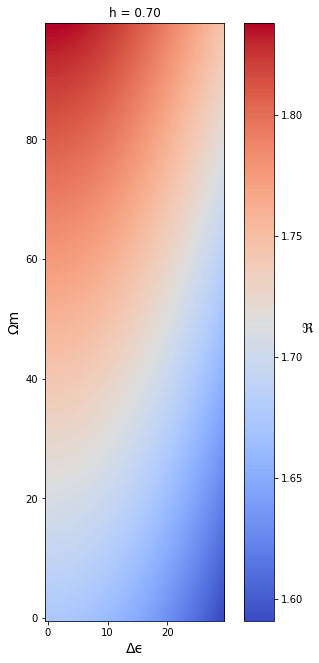

In [9]:
# i = h; j = Ωm; k = ΔE
xgridE = np.zeros(1)
ygridΩ = np.zeros(1)
def get_labels(narr):
    ticks = []
    for i in range(len(narr)):
        if i % 2 == 0:
            ticks.append(narr[i])
        else:
            ticks.append('')
            
    return ticks

bestdiff = 1000
bestj = 0
bestk = 0
for i in range(len(hscale)):
    plt.figure(figsize = (7, 11))
    plt.title('h = %.2f' % (hscale[i]))
    plt.xlabel('Δϵ', fontsize = 14)
    plt.ylabel('Ωm', fontsize = 14)
    
    fheatplt = plt.imshow(heatplt[i][:][:], cmap = 'coolwarm', interpolation = 'spline16')#,  vmin = 1.68, vmax = 1.74)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    #plt.xticks(ticks = np.arange(len(ΔE)), labels = [('%.4f' % ΔE[k]) for k in range(len(ΔE))], rotation = 45)
    #plt.xticks(ticks = np.arange(len(ΔE)), labels = get_labels(ΔE), rotation = 45)
    #ax.set_xticks(get_labels(ΔE))
    #plt.yticks(ticks = np.arange(len(Ωm)), labels = [('%.4f' % Ωm[j]) for j in range(len(Ωm))])
    
    
    cb = plt.colorbar(fheatplt)
    cb.set_label('ℜ', fontsize = 14, rotation = 360)
    for j in range(len(Ωm)):
        for k in range(len(ΔE)):
            if ((heatplt[i][j][k] <= 1.74) and (heatplt[i][j][k] >= 1.68)):
                #plt.scatter(heatplt[i][j][k], heatplt[i][j][k])
                #ax.text(k, j, ('%.2f' % heatplt[i][j][k]), ha = 'center', va = 'center', color = 'k', fontsize = 7)
                #print('ℜ = %.3f' % heatplt[i][j][k], 'at Ωm ind %s' % j, 'for Ωm = %.3f' % Ωm[j], 'at ΔE ind %s' % k, 'for ΔE = %.3f' % ΔE[k])
                #if ((ΔE[k] < tt[1]) and (ΔE[k] > tt[0])):
                #    print('ℜ = %.3f' % heatplt[i][j][k], 'at Ωm ind %s' % j, 'for Ωm = %.3f' % Ωm[j], 'at ΔE ind %s' % k, 'for ΔE = %.3f' % ΔE[k])
                diff = abs(heatplt[i][j][k] - 1.71)
                if bestdiff > diff:
                    bestdiff = diff
                    bestj = j
                    bestk = k
                
                #if (len(xgridE) == 1):
                #    xgridE[0] = ΔE[k]
                #    ygridΩ[0] = Ωm[j]
                #else:
                #    xgridE = np.append(xgridE, ΔE[k])
                #    ygridΩ = np.append(ygridΩ, Ωm[j])
plt.show()

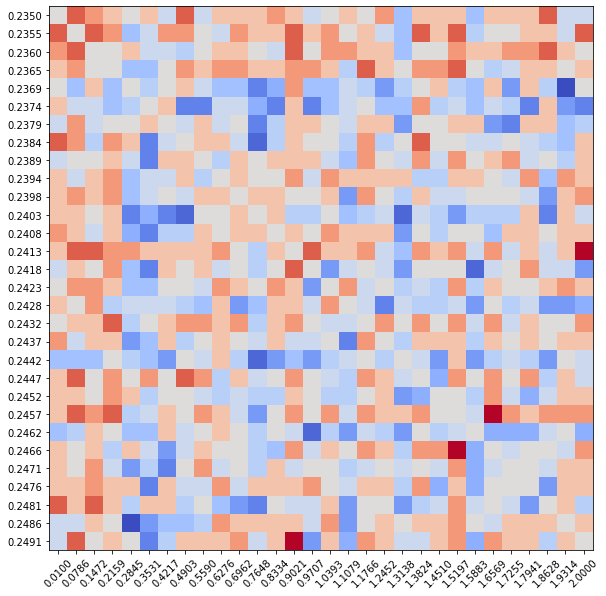

In [10]:
import pandas as pd

plt.figure(figsize = (10, 10))
dataset = pd.DataFrame(data = heatplt[0][:][:])
corr = dataset.corr()
plt.xticks(ticks = np.arange(len(ΔE)), labels = [('%.4f' % ΔE[k]) for k in range(len(ΔE))], rotation = 45)
plt.yticks(ticks = np.arange(len(Ωm)), labels = [('%.4f' % Ωm[j]) for j in range(len(Ωm))])
plt.imshow(corr, cmap = 'coolwarm', interpolation = 'nearest')
plt.show()

In [54]:
for i in range(len(ΔE)):
    print(inst[i].ℜ)

1.7273970887331536
1.7027685084499682
1.640930403688275


In [13]:
for i in range(len(ΔE)):
    print(inst[i].ℜ)

1.8784219000534632
1.8516577858857823
1.7844578932243447


In [11]:
# Creates the object associated with ΛCDM values (and empty and vacuum dominated universes)
instCDM = ΛCDM(zΛCDM = np.zeros(shared.n), dLΛspl = ini_spl, dLEmpspl = ini_spl, dLVacspl = ini_spl, dLΛinterp = np.zeros(shared.n), dLEmpinterp = np.zeros(shared.n), dLVacinterp = np.zeros(shared.n))
%time instCDM.calc_zΛCDM()
%time instCDM.dL_ΛCDM()

intR = lambda z : 1.0 / math.sqrt(instCDM.Ωm * (1.0 + z)**3.0 + instCDM.ΩΛ)
cdmR = math.sqrt(instCDM.Ωm) * integrate.quad(intR, 0, 1000)[0]

Ωmpl = .295+.034
Ωmmn = .295-.034
intRpl = lambda z : 1.0 / math.sqrt(Ωmpl * (1.0 + z)**3.0 + (1.0-Ωmpl))
intRmn = lambda z : 1.0 / math.sqrt(Ωmmn * (1.0 + z)**3.0 + (1.0-Ωmmn))
cdmRpl = math.sqrt(Ωmpl) * integrate.quad(intRpl, 0, 1100)[0]
cdmRmn = math.sqrt(Ωmmn) * integrate.quad(intRmn, 0, 1100)[0]
print('plus:', cdmRpl)
print('minus:', cdmRmn)
print('\n')
print('high:', cdmRpl-cdmR)
print('low:', cdmR - cdmRmn)
print('\n')
print('ℜ = ', cdmR)
print(' -- done with ΛCDM -- ')

Wall time: 0 ns
Wall time: 560 ms
plus: 1.765620949522703
minus: 1.726128556474435


high: 0.018570318126641228
low: 0.020922074921626788


ℜ =  1.7470506313960619
 -- done with ΛCDM -- 


In [12]:
# Opens binned distance modulus supernova data

sn_raw_mod = []
n_rows_mod = 0

with open('jla_likelihood_v6\data\jla_mub.txt', 'r') as reader:
    for line in reader:
        #print(line, end = '')
        sn_raw_mod.append(line)
        n_rows_mod += 1
        
col_num = 2
s = (n_rows_mod - 1, col_num)
sn_data_mod = np.zeros(s)
zb_mod = np.zeros(n_rows_mod - 1)
μb_mod = np.zeros(n_rows_mod - 1)

for i in range(1, n_rows_mod):
    split = sn_raw_mod[i].split()
    for j in range(col_num):
        sn_data_mod[i - 1][j] = split[j]
        zb_mod[i - 1] = split[0]
        μb_mod[i - 1] = split[1]

print(' -- done loading binned table -- ')


 -- done loading binned table -- 


 -- done resizing -- 
Wall time: 0 ns
True
 -- done symmetrizing / transposing C matrix -- 


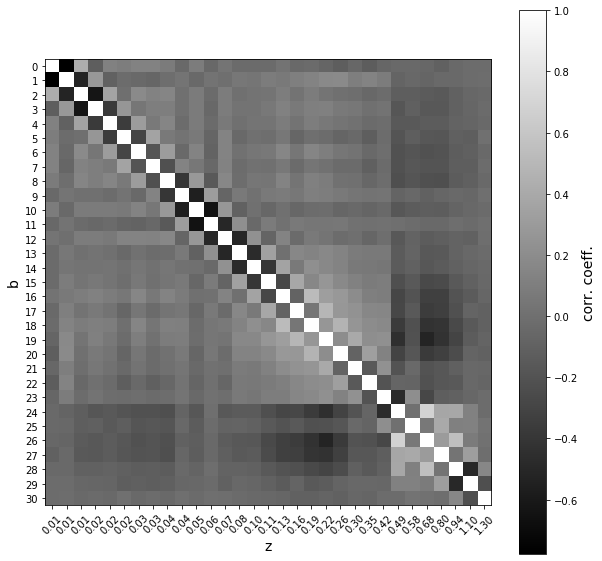

In [130]:
# Creates the convariant matrix of the binned distance modulus and its inverse

def res(d_array): return np.concatenate( (np.zeros(dim_row - len(d_array)), d_array), axis = None )

dim_row = 31

C = np.array([
              res([21282, -10840, 1918, 451, 946, 614, 785, 686, 581, 233, 881, 133, 475, 295, 277, 282, 412, 293, 337, 278, 219, 297, 156, 235, 133, 179, -25, -106,   0, 137, 168]),
              res([28155,  -2217, 1702,  74, 322, 380, 273, 424, 487, 266, 303, 406, 468, 447, 398, 464, 403, 455, 468, 417, 444, 351, 399,  83, 167, -86,  15,   -2,  76, 243]),
              res([ 6162,  -1593, 1463, 419, 715, 580, 664, 465, 613, 268, 570, 376, 405, 352, 456, 340, 412, 355, 317, 341, 242, 289, 119, 152, -69, -33, -44,   37, 209]),
              res([ 5235,   -722,  776, 588, 591, 583, 403, 651, 212, 555, 353, 355, 323, 442, 319, 372, 337, 288, 343, 210, 272,  92, 167, -48, -29, -21,  50,  229]),
              res([ 7303,   -508, 1026, 514, 596, 315, 621, 247, 493, 320, 375, 290, 383, 286, 350, 300, 269, 313, 198, 251,  99, 126,  18,  46,  13,  10, 203]),
              res([ 3150,   -249,  800, 431, 358, 414, 173, 514, 231, 248, 221, 293, 187, 245, 198, 175, 231, 126, 210, 103, 170,  51,  66,  -8, -51, 308]),
              res([ 3729,    -88,  730, 321, 592, 188, 546, 316, 342, 290, 389, 267, 341, 285, 252, 301, 189, 242, 122, 159,  35,  72,  30,  28, 255]),
              res([ 3222,   -143,  568, 421, 203, 491, 257, 280, 240, 301, 221, 275, 227, 210, 249, 148, 220, 123, 160,  43,  69,  27,   7, 253]),
              res([ 3225,   -508,  774, 156, 502, 273, 323, 276, 370, 260, 316, 273, 231, 273, 171, 226, 111, 154,   0,  29,  19,  23, 206]),
              res([ 5646,  -1735,  691, 295, 362, 316, 305, 370, 280, 346, 313, 276, 310, 217, 274, 131, 175,  38, 118,  78,  48, 303]),
              res([ 8630,  -1642,  944, 152, 253, 184, 274, 202, 254, 233, 196, 237, 156, 207,  27, 115, -32,   7, -15,   0, 176]),
              res([ 3855,   -754,  502, 225, 278, 294, 274, 285, 253, 239, 255, 173, 229, 181, 177,  93, 124, 132, 108, 227]),
              res([ 4340,   -634,  660, 240, 411, 256, 326, 276, 235, 290, 184, 256, 135, 222,  90, 152,  67,  17, 318]),
              res([ 2986,   -514,  479, 340, 363, 377, 362, 315, 343, 265, 311, 144, 198,  17,  62,  86, 147, 226]),
              res([ 3592,   -134,  606, 333, 422, 374, 333, 349, 267, 300, 157, 184,   9,  71,  85, 136, 202]),
              res([ 1401,     22,  431, 343, 349, 302, 322, 245, 284, 171, 186,  70,  70,  93, 142, 202]),
              res([ 1491,    141,  506, 386, 356, 394, 278, 306, 188, 212,  79,  71, 106, 145, 240]),
              res([ 1203,    200,  435, 331, 379, 281, 311, 184, 209,  49,  51, 110, 197, 181]),
              res([ 1032,    258,  408, 398, 305, 330, 197, 223,  78,  79, 113, 174, 225]),
              res([ 1086,    232,  453, 298, 328, 120, 189, -48,  22,  42, 142, 204]),
              res([ 1006,    151,  329, 282, 169, 195,  58,  80,  95, 192, 188]),
              res([ 1541,    124,  400, 199, 261, 150, 166, 202, 251, 251]),
              res([ 1127,     72,  227, 222,  93, 118,  93, 171, 161]),
              res([ 1723,   -105,  406,  -3, 180, 190, 198, 247]),
              res([ 1550,    144,  946, 502, 647, 437, 215]),
              res([ 1292,    187,  524, 393, 387, 284]),
              res([ 3941,    587, 1657, 641, 346]),
              res([ 2980,    360, 1124, 305]),
              res([ 4465,  -1891,  713]),
              res([23902,  -1826]),
              res([19169])
            ])

C = 1.0e-6 * C

print(' -- done resizing -- ')

for i in range(1, dim_row):
    if i == 1:
        C[1][0] = C[0][1]
    else:
        for j in range(i):
            C[i][j] = C[j][i]
            
%time C_inv = np.linalg.inv(C)


print(np.allclose(np.dot(C_inv, C), np.eye(31)))


print(' -- done symmetrizing / transposing C matrix -- ')

# The distance modulus error bars are the square roots of the diagonal
err = [np.sqrt(C[i][i]) for i in range(dim_row)]


plt.figure(figsize = (10, 10))
dataset = pd.DataFrame(data = C)
corr = dataset.corr()
plt.xticks(ticks = np.arange(len(zb_mod)), labels = [('%.2f' % zb_mod[k]) for k in range(len(zb_mod))], rotation = 45)
plt.yticks(ticks = np.arange(len(μb_mod)), labels = [j for j in range(len(μb_mod))])
cm = plt.imshow(corr, cmap = 'gray', interpolation = 'nearest')
cb = plt.colorbar(cm)
cb.set_label('corr. coeff.', fontsize = 14)
plt.xlabel('z', fontsize = 14)
plt.ylabel('b', fontsize = 14)
plt.show()

ΔE = 0.010 || M = 0.15916  || χ2 = 47.29865
ΔE = 0.079 || M = 0.15916  || χ2 = 47.19355
ΔE = 0.147 || M = 0.15816  || χ2 = 46.93002
ΔE = 0.216 || M = 0.15616  || χ2 = 46.51159
ΔE = 0.284 || M = 0.15315  || χ2 = 45.94466
ΔE = 0.353 || M = 0.14915  || χ2 = 45.24087
ΔE = 0.422 || M = 0.14515  || χ2 = 44.41371
ΔE = 0.490 || M = 0.14014  || χ2 = 43.47822
ΔE = 0.559 || M = 0.13413  || χ2 = 42.45243
ΔE = 0.628 || M = 0.12713  || χ2 = 41.35737
ΔE = 0.696 || M = 0.12012  || χ2 = 40.21961
ΔE = 0.765 || M = 0.11211  || χ2 = 39.06352
ΔE = 0.833 || M = 0.10310  || χ2 = 37.91725
ΔE = 0.902 || M = 0.09309  || χ2 = 36.81346
ΔE = 0.971 || M = 0.08308  || χ2 = 35.78435
ΔE = 1.039 || M = 0.07207  || χ2 = 34.86589
ΔE = 1.108 || M = 0.06106 || χ2 = 34.09269
ΔE = 1.177 || M = 0.04905 || χ2 = 33.50468
ΔE = 1.245 || M = 0.03704 || χ2 = 33.14014
ΔE = 1.314 || M = 0.02402 || χ2 = 33.03832
ΔE = 1.382 || M = 0.01001 || χ2 = 33.23925
ΔE = 1.451 || M = -0.00400 || χ2 = 33.78121
ΔE = 1.520 || M = -0.01802 || χ2 = 34

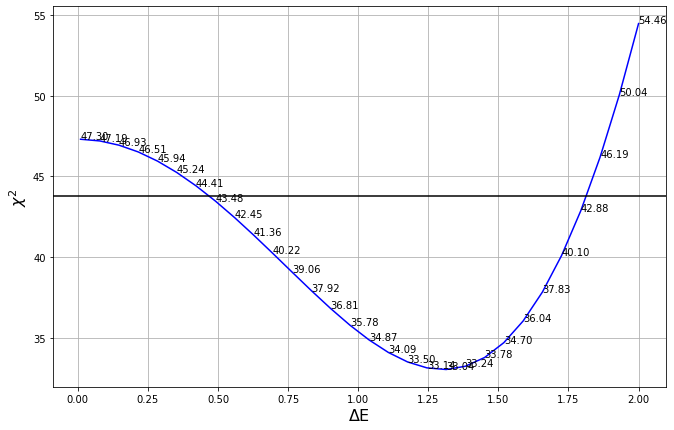

In [14]:
h0 = 100.0 * h_scale
convert = c / h0 * 1.0e6 / 10.0

def find_M(zb_mod, μb_frm, dL_mat, C_inv):
    '''
    # This is for a course grid that was meant to speed up the fine calculation by finding an approximate value of m to calculate around.
    # It ends up breaking the fine calculation, though. The fine calculation is already fast and doesn't need to have a very high fine
    #    grid anyway beacuse we don't need that high of precision (grid doesn't need to be ~10,000: ~1000 is fine).
    num_m = 100
    m = np.linspace(-1, 1, num = 100, endpoint = True)
    M_mat = np.ones((dim_row, 1))
    χ_to_min = np.linspace(0, num_m, num = num_m, endpoint = True)
    #χ_to_min = [i for i in range(num_m)]
    
    for i in range(len(m)):
        r_mat = μb_frm - M_mat * m[i] - dL_mat
        r_dagger_mat = np.transpose(r_mat)  
        χ_to_min[i] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
    
    χmin_ind = np.argmin(χ_to_min)
    χmin = min(χ_to_min)
    print('χmin_ind (100 grid):', χmin_ind) ###
    print('χmin (100 grid):', χmin) ###
    print('m (100 grid):', m[χmin_ind]) ###
    '''
    
    grid_size = 1000
    χmin_fine_low  = np.zeros(grid_size)
    χmin_fine_high = np.zeros(grid_size)
    
    st = 0
    nd = 1
    
    mmin_fine_low  = np.linspace(st, -nd, num = grid_size, endpoint = True)
    mmin_fine_high = np.linspace(st,  nd, num = grid_size, endpoint = True)
    
    new_m = np.zeros((dim_row, 1))
    
    for j in range(grid_size):
        fine_m = new_m + mmin_fine_low[j]
            
        r_mat = μb_frm - fine_m - dL_mat
        r_dagger_mat = np.transpose(r_mat)
        χmin_fine_low[j] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
        
        fine_m = new_m + mmin_fine_high[j]
        
        r_mat = μb_frm - fine_m - dL_mat
        r_dagger_mat = np.transpose(r_mat)
        χmin_fine_high[j] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
        
    χlow_fine = min(χmin_fine_low)
    χhigh_fine = min(χmin_fine_high)
    
    #-----------------------------------Debug--------------------------------------------#
    #print('fine_m low:', (new_m + mmin_fine_low[np.argmin(χlow_fine)])[0])
    #print('fine_m high:', (new_m + mmin_fine_high[np.argmin(χhigh_fine)])[0])
    #print('χlow_fine: %f, χhigh_fine: %f' % (χlow_fine, χhigh_fine)) ###
    #print('argmin(χlow_fine):', np.argmin(χlow_fine)) ###
    #print('argmin(χhigh_fine):', np.argmin(χhigh_fine)) ###
    #print('mmin_fine_low[argmin(χlow_fine)]:', mmin_fine_low[np.argmin(χlow_fine)]) ###
    #print('\n')
    #------------------------------------------------------------------------------------#
    
    if χlow_fine < χhigh_fine:
        mindex = np.argmin(χmin_fine_low)
        return χlow_fine, mmin_fine_low[mindex]
    elif χhigh_fine < χlow_fine:
        mindex = np.argmin(χmin_fine_high)
        return χhigh_fine, mmin_fine_high[mindex]
    else:
        mindex = np.argmin(χmin_fine_low)
        return χlow_fine, mmin_fine_low[mindex]
    

def χsq_calc(zb_mod, μb_mod, dLtheory, C_inv):
    
    dL_mat = np.zeros((dim_row, 1))
    μb_frm = np.zeros((dim_row, 1))
    
    for i in range(dim_row):
        dL_mat[i] = 5.0 * np.log(dLtheory(zb_mod[i]) * convert) / np.log(10.0)
        μb_frm[i] = μb_mod[i]
    
    χ2, mmin = find_M(zb_mod, μb_frm, dL_mat, C_inv)   

    return χ2, mmin

def get_model(ind, χsq):
    if ind < len(ΔE):
        return 'ΔE min = %.2f at index %s' % (ΔE[index_min], ind)
    elif ind == len(ΔE):
        return 'ΛCDM, Ωm = %.2f with χ2 = %.2f' % (ΛCDM.Ωm, χsq[ind])
    elif ind == (len(ΔE) + 1):
        return 'an empty universe'
    elif ind == (len(ΔE) + 2):
        return 'a vacuum dominated universe'
    
χsq   = np.zeros(len(ΔE) + 3)
M_min = np.zeros(len(ΔE) + 3)

for i in range(len(χsq)):
    if i < len(ΔE):
        #χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, inst[i].dLBspl, C_inv)
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, heatΩmE[i][0][0].dLBspl, C_inv)
        if i <= len(ΔE)/2.0:
            print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
        else:
            print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
    elif i == len(ΔE):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLΛspl, C_inv)
        print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
    elif i == (len(ΔE) + 1):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLEmpspl, C_inv)
        print('Empty      || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
    elif i == (len(ΔE) + 2):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLVacspl, C_inv)
        print('Vacuum     || M = %.5f || χ2 = %.5f' % (M_min[i], χsq[i]))
        
print('\n')
print('χ2:', χsq)
print('\n')
print('Min of χ2: %.5f' % min(χsq))
print('Min of ΔE χ2: %.5f' % min(χsq[0:len(ΔE)]))
index_min = np.argmin(χsq[:])
index_min_Bb = np.argmin(χsq[0:len(ΔE)])
print('This corresponds to', get_model(index_min, χsq))
print('\n')

signifInd = np.zeros(1)
signifE = np.zeros(1)
setInd = True
print(' ----- Significant models for dof = 30, p<= .05 ----- ')
for i in range(len(ΔE) + 3):
    if χsq[i] <= 43.773:
        
        if i < len(ΔE):
        #χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, inst[i].dLBspl, C_inv)
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, heatΩmE[i][0][0].dLBspl, C_inv)
            if (setInd):
                signifInd[0] = i
                signifE[0] = ΔE[i]
                setInd = False
            else:
                signifInd = np.append(signifInd, i)
                signifE = np.append(signifE, ΔE[i])
                
            if i <= len(ΔE)/2.0:
                print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
            else:
                print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
        elif i == len(ΔE):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLΛspl, C_inv)
            print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
        elif i == (len(ΔE) + 1):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLEmpspl, C_inv)
            print('Empty      || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
        elif i == (len(ΔE) + 2):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLVacspl, C_inv)
            print('Vacuum     || M = %.5f || χ2 = %.5f' % (M_min[i], χsq[i]))

print('---------------------------------------------------')
print('significant indices:', signifInd)
print(signifE)

plt.figure(figsize = (11, 7))
plt.plot(ΔE, χsq[0:n_ΔE + 1], 'b')
for i, j in zip(ΔE, χsq[:]): plt.annotate('%.2f' % j, xy = (i, j), textcoords = 'data')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('$χ^2$', fontsize = 16)
plt.axhline(y = 43.773, xmin = 0, xmax = 2, color = 'k')
plt.grid()
plt.show()

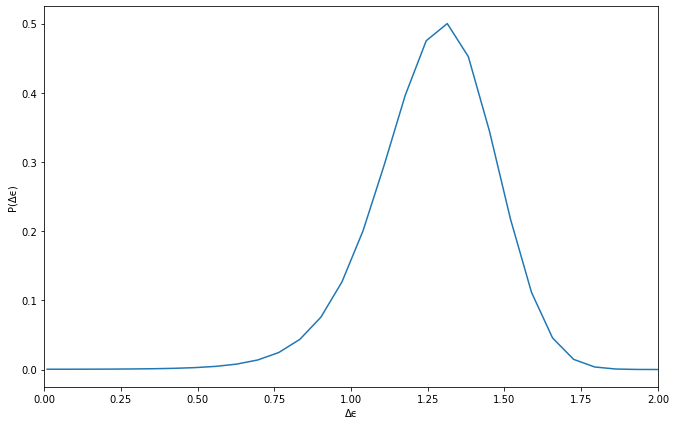

In [15]:
prob = [.5*math.exp(-.5 * χsq[i])/math.exp(-.5 * np.min(χsq[0:len(ΔE)])) for i in range(len(ΔE))]
plt.figure(figsize = (11, 7))
plt.plot(ΔE, prob)
plt.xlabel('Δϵ')
plt.ylabel('P(Δϵ)')
plt.xlim(0, 2)
plt.show()

(1.049542778906857, 1.234939979713833)
1.142241379310345
upper 0.09270
lower 0.09270


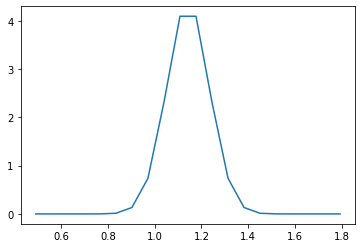

In [16]:
tt = st.t.interval(alpha = .68, df = len(signifE)-1, loc=np.mean(signifE), scale=st.sem(signifE))
print(tt)
print(np.mean(signifE))
print('upper %.5f' % (tt[1] - np.mean(signifE)))
print('lower %.5f' % (np.mean(signifE) - tt[0]))

pdf = st.norm.pdf(x = signifE, loc = np.mean(signifE), scale = st.sem(signifE))
plt.plot(signifE, pdf)

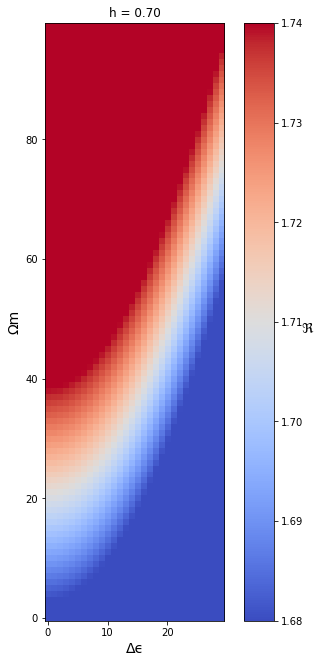

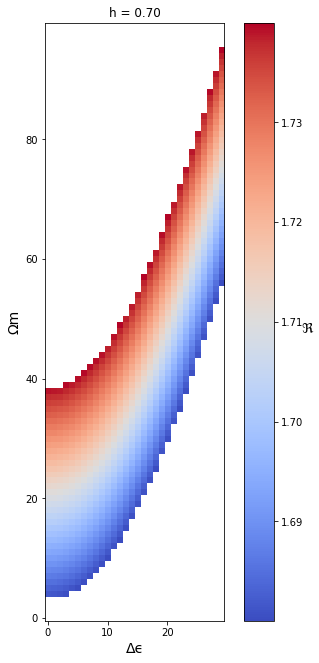

In [59]:
# i = h; j = Ωm; k = ΔE

xgridE = np.zeros(1)
ygridΩ = np.zeros(1)
zgridℜ = np.zeros(1)
statgrid = np.zeros((nΩm, len(ΔE)))
statgrid2 = np.zeros((nΩm, len(ΔE)))
for i in range(len(hscale)):
    plt.figure(figsize = (7, 11))
    plt.title('h = %.2f' % (hscale[i]))
    plt.xlabel('Δϵ', fontsize = 14)
    plt.ylabel('Ωm', fontsize = 14)
    #plt.xticks(ticks = np.arange(len(ΔE)), labels = [('%.4f' % ΔE[k]) for k in range(len(ΔE))], rotation = 45)
    #plt.yticks(ticks = np.arange(len(Ωm)), labels = [('%.4f' % Ωm[j]) for j in range(len(Ωm))])
    fheatplt = plt.imshow(heatplt[i][:][:], cmap = 'coolwarm', interpolation = 'nearest',  vmin = 1.68, vmax = 1.74)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    cb = plt.colorbar(fheatplt)
    cb.set_label('ℜ', fontsize = 14, rotation = 360)
    for j in range(len(Ωm)):
        for k in range(len(ΔE)):
            if ((heatplt[i][j][k] <= 1.74) and (heatplt[i][j][k] >= 1.68)):
                #plt.scatter(heatplt[i][j][k], heatplt[i][j][k])
                #ax.text(k, j, ('%.2f' % heatplt[i][j][k]), ha = 'center', va = 'center', color = 'k', fontsize = 7)
                #print('ℜ = %.3f' % heatplt[i][j][k], 'at Ωm ind %s' % j, 'for Ωm = %.3f' % Ωm[j], 'at ΔE ind %s' % k, 'for ΔE = %.3f' % ΔE[k])
                statgrid[j][k] = heatplt[i][j][k]
                #if (len(xgridE) == 1):
                #    xgridE[0] = ΔE[k]
                #    ygridΩ[0] = Ωm[j]
                #    zgridℜ[0] = heatplt[i][j][k]
                #else:
                #    xgridE = np.append(xgridE, ΔE[k])
                #    ygridΩ = np.append(ygridΩ, Ωm[j])
                #    zgridℜ = np.append(zgridℜ, heatplt[i][j][k])
plt.show()

mask = np.zeros_like(statgrid, dtype = bool)
mask2 = np.zeros_like(statgrid, dtype = bool)
#xymesh = np.meshgrid(xgridE, ygridΩ, sparse=True)
#h = plt.contour(xgridE, ygridΩ, zgridℜ)
#plt.plot(xymesh)
#plt.show()
plt.figure(figsize = (7, 11))#, dpi = 150)
plt.title('h = %.2f' % (hscale[i]))
plt.xlabel('Δϵ', fontsize = 14)
plt.ylabel('Ωm', fontsize = 14)

for j in range(len(Ωm)):
    for k in range(len(ΔE)):
        
        
        if ((heatplt[0][j][k] > 1.74) or (heatplt[0][j][k] < 1.68)):
            mask[j, k] = True
            mask2[j, k] = True
        if k not in signifInd:
            mask2[j, k] = True
            
            
        if ((heatplt[0][j][k] < 1.74) and (heatplt[0][j][k] > 1.68)):
            diff = abs(heatplt[0][j][k] - 1.71)
            if bestdiff > diff:
                bestdiff = diff
                bestj = j
                bestk = k
        #if k in signifInd:
            
            
        #if ((ΔE[k] > tt[1]) or (ΔE[k] < tt[0])):
        #    mask[j, k] = True
        #    #print('ℜ = %.3f' % heatplt[i][j][k], 'at Ωm ind %s' % j, 'for Ωm = %.3f' % Ωm[j], 'at ΔE ind %s' % k, 'for ΔE = %.3f' % ΔE[k])

statgrid = np.ma.array(statgrid, mask = mask)
statgrid2 = np.ma.array(statgrid2, mask = mask2)
corner_mask = False
#cs = ax.contourf(ΔE, Ωm, statgrid)#, corner_mask = corner_mask)
#ax.contourf(cs, colors = 'k')

#ax.contourf(ΔE, Ωm, statgrid)

#plt.xticks(ticks = np.arange(len(ΔE)), labels = [('%.4f' % ΔE[k]) for k in range(len(ΔE))], rotation = 45)
#plt.yticks(ticks = np.arange(len(Ωm)), labels = [('%.4f' % Ωm[j]) for j in range(len(Ωm))])
fheatpltgrid = plt.imshow(statgrid, cmap = 'coolwarm', interpolation = 'nearest')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
cb = plt.colorbar(fheatpltgrid)
cb.set_label('ℜ', fontsize = 14, rotation = 360)
#plt.savefig('R-ELimit')
plt.show()


In [65]:
x, y = np.meshgrid(ΔE, Ωm)

mskplt = np.ndarray(((n_ΔE + 1), len(Ωm),), dtype = np.longdouble).reshape((len(Ωm), (n_ΔE + 1)))

for j in range(len(Ωm)):
    for k in range(len(ΔE)):      
        
        if ((heatplt[i][j][k] > 1.74) or (heatplt[i][j][k] < 1.68)):
            mskplt[j][k] = 0
        else:
            mskplt[j][k] = statgrid[j][k]
        #if k not in signifInd:
        #    mskplt[j, k] = 0
        #else:
        #    mskplt[j][k] = heatplt[0][j][k]
            
        #if ((ΔE[k] > tt[1]) or (ΔE[k] < tt[0])):
        #    mask[j, k] = 0
        #else:
        #    mskplt[j][k] = heatplt[0][j][k]




#from scipy import ndimage
#ff = heatplt[0][:][:]
#print(ff)
#z_interp = ndimage.zoom(ff, 3)
#print(z_interp)
'''
x_, y_ = np.meshgrid(
                        np.linspace(-3, 3, z_grid_interp.shape[1]), 
                         np.linspace(1, 2, z_grid_interp.shape[0])
                    )
x_, y_ = np.meshgrid()
'''
print(bestdiff, bestj, Ωm[bestj], bestk, ΔE[bestk])
print(ΔE[int(signifInd[0])])

9.011852119722441e-05 72 0.2699090909090909 28 1.9313793103448276
0.4903448275862069


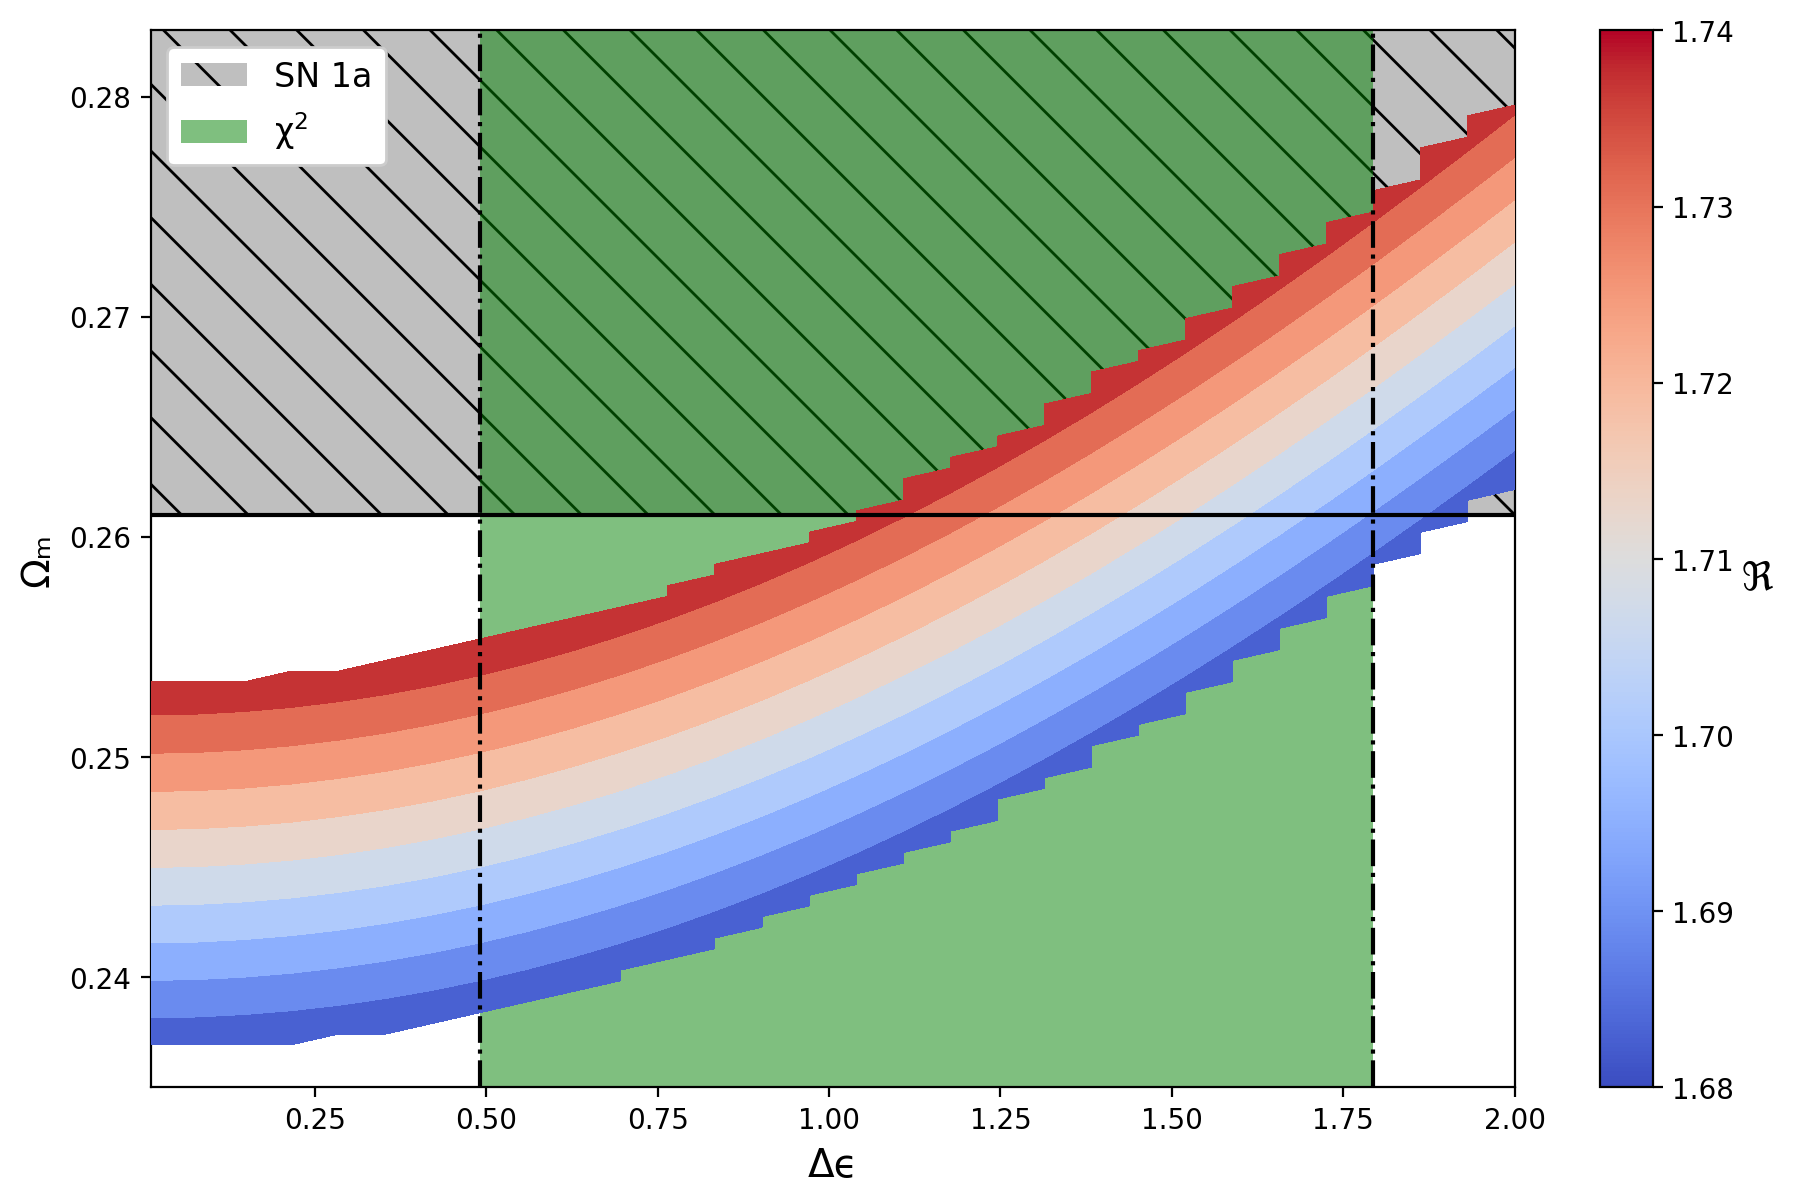

In [155]:
plt.figure(figsize = (11, 7), dpi = 200)
#ax1=plt.contourf(x, y, heatplt[0][:][:], 20, cmap = 'coolwarm')
rectangle = plt.Rectangle((0, .261), 2, .034, fc = 'gray', alpha = .5, label = 'SN 1a', hatch = '\\', zorder = 2)#ec = 'black'
plt.gca().add_patch(rectangle)
plt.axhline(y = .261, xmin = 0, xmax = 2, ls = '-', color = 'k', zorder = 5)

rectangle2 = plt.Rectangle((ΔE[int(signifInd[0])], .235), (ΔE[int(signifInd[-1])] - ΔE[int(signifInd[0])]), (Ωm[-1] - Ωm[0]), fc = 'green', alpha = .5, label = 'χ$^2$', zorder = 2.5)# hatch = '/'
plt.gca().add_patch(rectangle2)
plt.axvline(x = ΔE[int(signifInd[0])], ls = '-.', color = 'k', zorder = 5.5)
plt.axvline(x = ΔE[int(signifInd[-1])], ls = '-.', color = 'k', zorder = 6)

plt.contourf(x, y, statgrid, 10, cmap = 'coolwarm', zorder = 3)
#plt.contourf(x, y, statgrid2, alpha = .5, zorder = 4)

cb = plt.colorbar(fheatplt)
cb.set_label('  ℜ', fontsize = 14, rotation = 360)
#plt.scatter(ΔE[bestk], Ωm[bestj], color = 'k')

plt.xlim(ΔE[0], ΔE[-1])
plt.ylim(Ωm[0], Ωm[-1])
plt.xlabel('Δϵ', fontsize = 14)
plt.ylabel('Ωₘ', fontsize = 14)
plt.legend(loc = 'upper left', framealpha = 1, prop = {'size': 12})
plt.savefig('R-para-space', dpi = 200)
plt.show()
#0.295 +- 0.034

In [22]:
#mn = np.zeros_like(statgrid)
#for i in range(len(hscale)):
#    for j in range(len(Ωm)):
#            for k in range(len(ΔE)):
#                mn[j, k] = heatplt[i][j][k] - 1.71

#p_value = chi2.sf(chi_statistic, df)
p_values = np.zeros(len(ΔE) + 3)
for i in range(len(ΔE) + 3):
    p_values[i] = st.chi2.sf(χsq[i], 30)
    
for i in p_values:
    print("%.3f" % i)

0.023
0.024
0.025
0.028
0.031
0.037
0.044
0.053
0.065
0.081
0.101
0.124
0.152
0.183
0.215
0.248
0.277
0.301
0.316
0.321
0.312
0.290
0.254
0.207
0.154
0.103
0.060
0.030
0.012
0.004
0.295
0.026
0.000


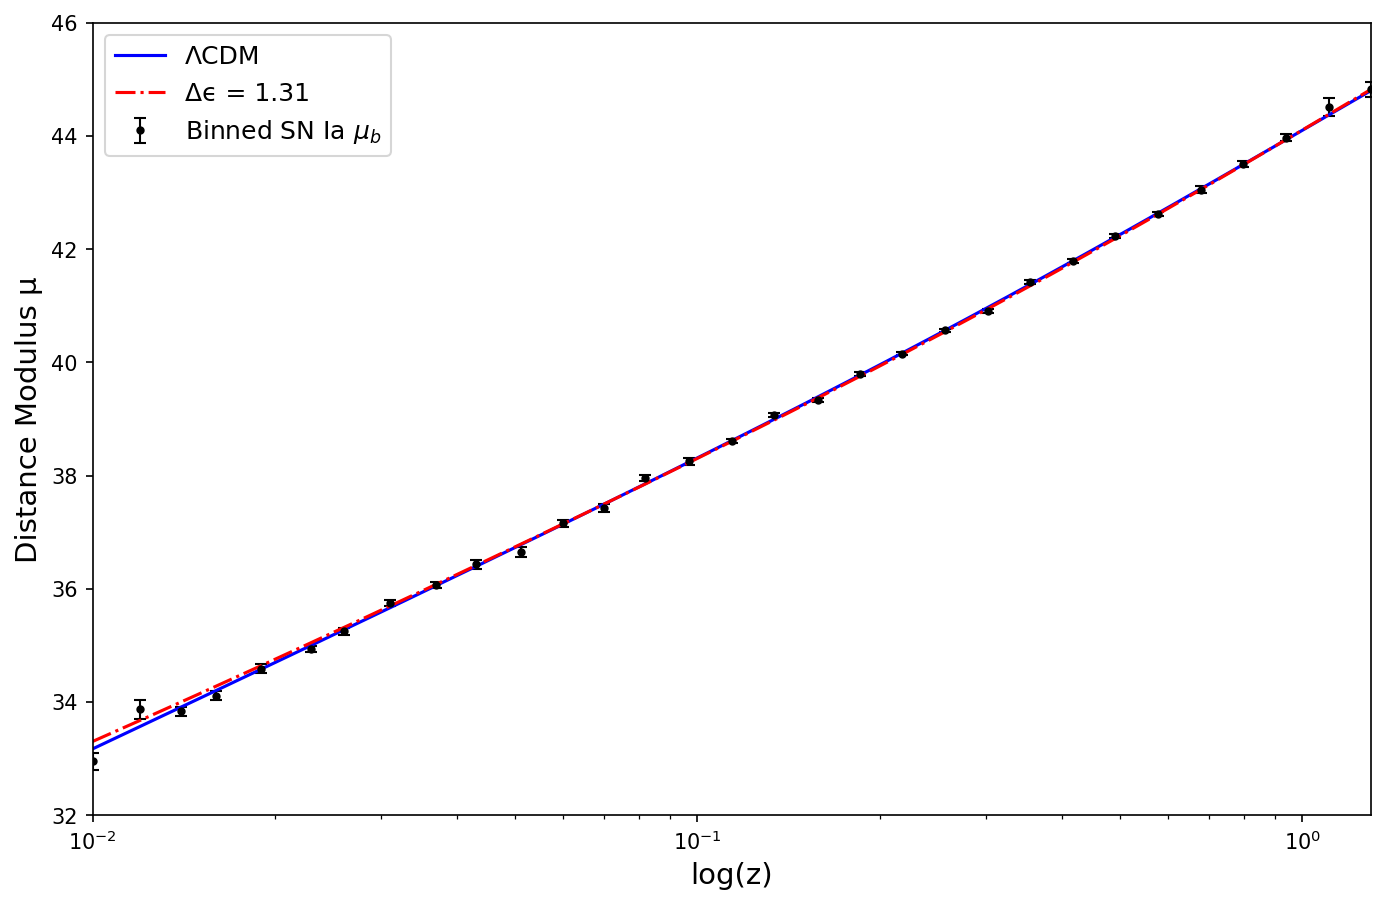

In [149]:
conv_dLB = np.zeros((n_ΔE + 1, shared.n))
plot_z = np.linspace(shared.zbegin, shared.zfinal, shared.n, endpoint = True)

for i in range(n_ΔE + 1):
    for j in range(1, shared.n):
        #conv_dLB[i][j - 1] = 5.0 * np.log(inst[i].dLBinterp[j] * convert) / np.log(10.0)
        conv_dLB[i][j - 1] = 5.0 * np.log(heatΩmE[i][0][0].dLBinterp[j] * convert) / np.log(10.0)
        
#conv_dLV = np.zeros(shared.n)
#conv_dLE = np.zeros(shared.n)
conv_dLΛ = np.zeros(shared.n)
    
for i in range(shared.n):
    #conv_dLE[i] = 5.0 * np.log(instCDM.dLEmpinterp[i] * convert) / np.log(10.0)
    #conv_dLV[i] = 5.0 * np.log(instCDM.dLVacinterp[i] * convert) / np.log(10.0)
    conv_dLΛ[i] = 5.0 * np.log(instCDM.dLΛinterp[i]   * convert) / np.log(10.0)
    
#plt.figure(figsize = (15, 12))
plt.figure(figsize = (11, 7), dpi = 150)
plt.errorbar(zb_mod, μb_mod, yerr = err, capsize = 3, elinewidth = 1, color = 'k', fmt = '.', label = 'Binned SN Ia $μ_b$')
    
#plt.plot(instCDM.zΛCDM, conv_dLV,    'g', label = 'Vacuum Dominated')
#plt.plot(instCDM.zΛCDM, conv_dLE,  '-.', label = 'Empty')
plt.plot(plot_z, conv_dLΛ,    'b', label = 'ΛCDM')#, $Ω_m$ = %.3f' % ΛCDM.Ωm)

#for i in range(len(ΔE)): plt.plot(plot_z, conv_dLB[i][:], label = ('ΔE = %.2f' % inst[i].E))
#for i in range(len(ΔE)): plt.plot(zz, conv_dLB[i][:], label = ('ΔE = %.2f' % inst[i].E))


#plt.plot(plot_z, conv_dLB[index_min_Bb][:], 'r-.', label = ('ΔE = %.2f' % inst[index_min_Bb].E))
plt.plot(plot_z, conv_dLB[index_min_Bb][:], 'r-.', label = ('Δϵ = %.2f' % heatΩmE[index_min_Bb][0][0].E))

plt.xlabel('log(z)', fontsize = 14)
plt.ylabel('Distance Modulus μ', fontsize = 14)
plt.xscale('log')
plt.xlim(.01, 1.3)
plt.ylim(32, 46)
plt.legend(loc = 'best', prop = {'size': 12})
#plt.grid()
#plt.savefig('dL_SN_01-1_no_grid', dpi = 150)
plt.show()

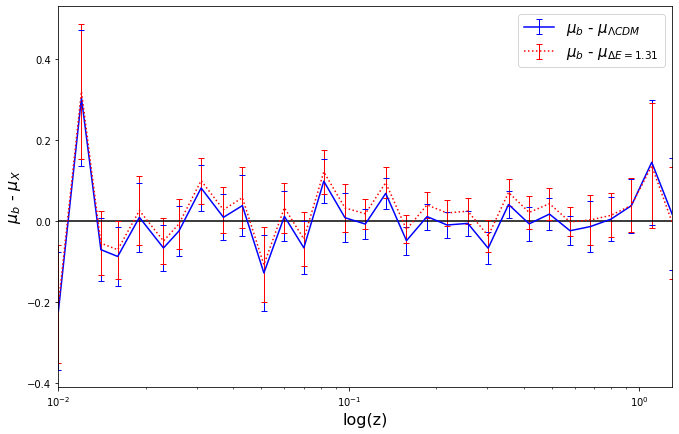

In [136]:
comp_CDM = [5.0 * np.log(instCDM.dLΛspl(zb_mod[i]) * convert) / np.log(10.0) for i in range(len(μb_mod))]
#comp_Bb = [5.0 * np.log(inst[index_min_Bb].dLBspl(zb_mod[j]) * convert) / np.log(10.0) for j in range(len(μb_mod))]
comp_Bb = [5.0 * np.log(heatΩmE[index_min_Bb][0][0].dLBspl(zb_mod[j]) * convert) / np.log(10.0) for j in range(len(μb_mod))]

plt.figure(figsize = (11, 7))
plt.plot(zb_mod, [comp_CDM[i] - comp_CDM[i] for i in range(len(comp_CDM))], color = 'k')
plt.errorbar(zb_mod, [μb_mod[i] - comp_CDM[i] for i in range(len(μb_mod))], yerr = err, color = 'b', capsize = 3, elinewidth = 1, label = '$μ_b$ - $μ_{ΛCDM}$')
#plt.errorbar(zb_mod, [μb_mod[i] - comp_Bb[i] for i in range(len(μb_mod))],  yerr = err, ls = ':', color = 'r', capsize = 3, elinewidth = 1, label = ('$μ_b$ - $μ_{ΔE = %.2f}$' % inst[index_min_Bb].E))
plt.errorbar(zb_mod, [μb_mod[i] - comp_Bb[i] for i in range(len(μb_mod))],  yerr = err, ls = ':', color = 'r', capsize = 3, elinewidth = 1, label = ('$μ_b$ - $μ_{ΔE = %.2f}$' % heatΩmE[index_min_Bb][0][0].E))
#plt.scatter(zb_mod, [abs(comp_Bb[i] - comp_CDM[i]) for i in range(len(μb_mod))], color = 'g', label = '|$μ_{ΔE = %.2f} - μ_{ΛCDM}$|' % inst[index_min_Bb].E)
#plt.scatter(zb_mod, [abs(comp_Bb[i] - comp_CDM[i]) for i in range(len(μb_mod))], color = 'g', label = '|$μ_{ΔE = %.2f} - μ_{ΛCDM}$|' % heatΩmE[index_min_Bb][0][0].E)
plt.xscale('log')
plt.xlabel('log(z)', fontsize = 16)
plt.ylabel('$μ_b$ - $μ_X$', fontsize = 16)
plt.legend(loc = 'best', prop = {'size': 15})
plt.xlim(.01, 1.3)
plt.show()

In [ ]:
fig1 = plt.figure(1)
frame1 = fig1.add_axes([zb_mod[0], zb_mod[-1], 32, 46])
plt.errorbar(zb_mod, μb_mod, yerr = err, capsize = 3, elinewidth = 1, color = 'k', fmt = '.', label = 'Binned SN Ia $μ_b$')
plt.plot(plot_z, conv_dLΛ,    'b', label = 'ΛCDM')#, $Ω_m$ = %.3f' % ΛCDM.Ωm)
plt.plot(plot_z, conv_dLB[index_min_Bb][:], 'r-.', label = ('Δϵ = %.2f' % heatΩmE[index_min_Bb][0][0].E))
plt.xscale('log')
frame1.set_xticklabels([])

frame2 = fig1.add_axes([zb_mod[0], zb_mod[-1], -.4, .5])
plt.plot(zb_mod, [comp_CDM[i] - comp_CDM[i] for i in range(len(comp_CDM))], color = 'k')
plt.errorbar(zb_mod, [μb_mod[i] - comp_CDM[i] for i in range(len(μb_mod))], yerr = err, color = 'b', capsize = 3, elinewidth = 1, label = '$μ_b$ - $μ_{ΛCDM}$')
plt.errorbar(zb_mod, [μb_mod[i] - comp_Bb[i] for i in range(len(μb_mod))],  yerr = err, ls = ':', color = 'r', capsize = 3, elinewidth = 1, label = ('$μ_b$ - $μ_{ΔE = %.2f}$' % heatΩmE[index_min_Bb][0][0].E))
plt.xscale('log')

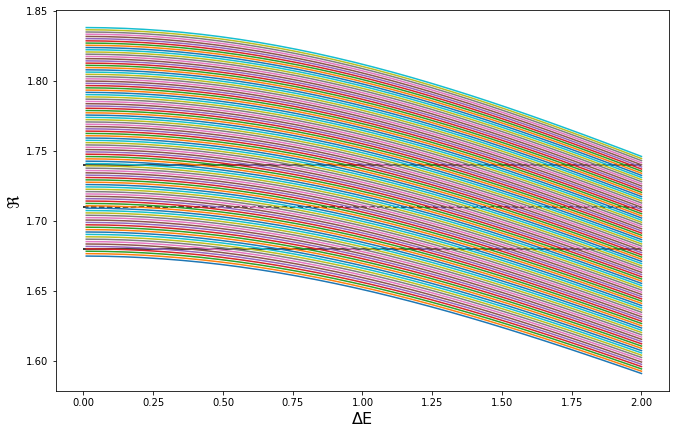

In [25]:
#print('ℜ of best fit: %.3f (ΔE = %.3f)' % (inst[index_min_Bb].ℜ, ΔE[index_min_Bb]))
plt.figure(figsize = (11, 7))
#plt.plot(ΔE, [inst[i].ℜ for i in range(n_ΔE + 1)], 'r')
for j in range(len(Ωm)):
    
    plt.plot(ΔE, [heatΩmE[i][j][0].ℜ for i in range(n_ΔE + 1)], label = ("Ωm = %.2f" % Ωm[j]))
#plt.scatter(ΔE[index_min_Bb], inst[index_min_Bb].ℜ, color = 'k', label = 'Best Fit')
#plt.scatter(ΔE[index_min_Bb], heatΩmE[index_min_Bb][0][0].ℜ, color = 'k', label = 'Best Fit')
plt.hlines(y = 1.71, xmin = 0, xmax = ΔE[n_ΔE], ls = '--', label = 'WMAP 1σ')
plt.hlines(y = 1.74, xmin = 0, xmax = ΔE[n_ΔE])
plt.hlines(y = 1.68, xmin = 0, xmax = ΔE[n_ΔE])
#plt.errorbar(ΔE[index_min_Bb], inst[index_min_Bb].ℜ, yerr = errtest, capsize = 3, elinewidth = 1, color = 'k', label = 'Best fit ΔE')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('ℜ', fontsize = 16)
#plt.legend()
#plt.xlim(0, ΔE[n_ΔE])
plt.show()

In [90]:
4.0 * (1e9)**(-1) * 1.6022e-10 / (3e8)**2

7.120888888888889e-36

In [29]:
chs = np.zeros(len(ΔE) + 1)
chs2= np.zeros(len(ΔE) + 1)
#e_mod = np.zeros((n_ΔE + 1, len(μb_mod)))
from scipy.stats import chisquare
ex = np.ones(n_ΔE + 1) * 1.71
ℜlist = [inst[i].ℜ for i in range(len(ΔE))]

#for i in range(n_ΔE + 1):
#    for j in range(0, len(μb_mod)):
#        e_mod[i][j] = 5.0 * np.log(inst[i].dLBspl(zb_mod[j]) * convert) / np.log(10.0)

for i in range(len(chs)):
    if i == len(ΔE):
        chs[i] = ((cdmR - 1.71)**2) / 1.71
    else:
        chs[i] = ((inst[i].ℜ - 1.71)**2) / 1.71      
        
print(chs)


for i in range(2):
    print(i)
    if i == 1:
        #print('LCDM:', chisquare(1.75, 1.71))
        print('--')
    else:
        print('ℜ ΔE:', chisquare(ℜlist, ex))
    

χ2total = [χsq[i] + chs[i] for i in range(len(ΔE) + 1)]
print(χsq[0:len(ΔE) + 1])
print(χ2total)

[0.01658827 0.01173505 0.00324209 0.00093519]
0
ℜ ΔE: Power_divergenceResult(statistic=0.03156540501935021, pvalue=0.9843411916881363)
1
--
[47.30038956 35.37640661 54.46153036 33.65354799]
[47.316977831723186, 35.388141656707596, 54.4647724504053, 33.654483180069846]


chi sq funct: Power_divergenceResult(statistic=0.000292149466418589, pvalue=0.9999999999224082)
ints[0]ℜ: 1.8784219000534632
var_array: [1.8784219000534632, 1.8773183596164502, 1.8739871235254175, 1.8685186357408896, 1.8610232361583383, 1.8516577858857823]
variation: 9.097962091889272e-05
χ2 of ℜ: [311.78340964 307.71103663 295.58022347 276.1954559  250.69370074
 220.56509028]
-----------------
χ2 total: [359.08379920230317, 354.33226364325935, 340.26826196220793, 318.00024479105247, 289.16596920620395, 255.9414968958237]


Text(0, 0.5, 'χ total')

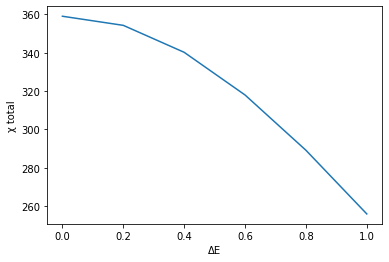

In [15]:
from scipy.stats import chisquare
var_array = [inst[i].ℜ for i in range(n_ΔE + 1)]
print('chi sq funct:', chisquare(var_array))
varℜ2 = np.var(var_array)
print('ints[0]ℜ:', inst[0].ℜ)
print('var_array:', var_array)
print('variation:', varℜ2)

χ2ℜ = np.zeros(n_ΔE + 1)
for i in range(n_ΔE + 1):
    χ2ℜ[i] = (inst[i].ℜ - 1.71)**2.0 / varℜ2
    
print('χ2 of ℜ:', χ2ℜ)
print('-----------------')
χ2total = [χsq[i] + χ2ℜ[i] for i in range(n_ΔE + 1)]
print('χ2 total:', χ2total)

plt.figure()
plt.plot(ΔE, χ2total[0:(n_ΔE+1)])
plt.xlabel('ΔE')
plt.ylabel('χ total')

In [19]:
import scipy.stats as stats
obs = np.ones(len(var_array)) * 1.71

stats.chisquare(f_obs = var_array, f_exp = obs)

Power_divergenceResult(statistic=0.16296210719026105, pvalue=0.9999999720332698)

In [ ]:
'''
##### fixed M code

h0 = 100.0 * h_scale
convert = c / h0 * 1.0e6 / 10.0


def χsq_calc(zb_mod, μb_mod, dLtheory, C_inv):
    
    M_mat  = np.ones((dim_row, 1)) * .05#-18.0 # Using only 1s => ΛCDM, if not => ΔE = ...
    dL_mat = np.zeros((dim_row, 1))
    μb_frm = np.zeros((dim_row, 1))
    
    for i in range(dim_row):
        dL_mat[i] = 5.0 * np.log(dLtheory(zb_mod[i]) * convert) / np.log(10.0)
        μb_frm[i] = μb_mod[i]
        
    r_mat = μb_frm - M_mat - dL_mat
    r_dagger_mat = np.transpose(r_mat)      
        
    χ2 = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
    
    return χ2

def χsq_ΛCDM(zb_mod, μb_mod, dLtheory, C_inv):
    μ_mat = np.zeros((dim_row, 1))
    μb_frm = np.zeros((dim_row, 1))
    
    for i in range(dim_row):
        μ_mat[i] = 5.0 * np.log(dLtheory(zb_mod[i]) * convert) / np.log(10.0)
        μb_frm[i] = μb_mod[i]
        
    sec = μb_frm - μ_mat
    fir = np.transpose(sec)
    
    χ2 = np.matmul(fir, np.matmul(C_inv, sec))
    
    return χ2

def get_model(ind, χsq):
    if ind < len(ΔE):
        return 'ΔE min = %.2f at index %s' % (ΔE[index_min], ind)
    
    elif ind == len(ΔE):
        return 'ΛCDM, Ωm = %.2f with χ2 = %.2f' % (ΛCDM.Ωm, χsq[ind])
    
    elif ind == (len(ΔE) + 1):
        return 'an empty universe'
    
    elif ind == (len(ΔE) + 2):
        return 'a vacuum dominated universe'
    
χsq = np.zeros(len(ΔE) + 3)

for i in range(len(χsq)):
    if i < len(ΔE):
        χsq[i] = χsq_calc(zb_mod, μb_mod, inst[i].dLBspl, C_inv)
        print('χ2 of ΔE = %.2f : %.2f ' % (ΔE[i], χsq[i]))
    elif i == len(ΔE):
        χsq[i] = χsq_ΛCDM(zb_mod, μb_mod, instCDM.dLΛspl, C_inv)
        print('χ2 of ΛCDM: %.2f' % χsq[i])
    elif i == (len(ΔE) + 1):
        χsq[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLEmpspl, C_inv)
        print('χ2 of empty universe: %.2f' % χsq[i])
    elif i == (len(ΔE) + 2):
        χsq[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLVacspl, C_inv)
        print('χ2 of vacuum dominated: %.2f' % χsq[i])
        
print('\n')
print('χ2:', χsq)
print('\n')
print('Min of χ2: %.5f' % min(χsq))
print('Min of ΔE χ2: %.5f' % min(χsq[0:len(ΔE)]))
index_min = np.argmin(χsq)
index_min_Bb = np.argmin(χsq[0:len(ΔE)])
print('This corresponds to', get_model(index_min, χsq))
print('\n')

plt.figure(figsize = (8, 6))
plt.plot(ΔE, χsq[0:n_ΔE + 1], 'b')
for i, j in zip(ΔE, χsq): plt.annotate('%.2f' % j, xy = (i, j), textcoords = 'data') #plt.annotate('(ΔE = %.2f, $χ^2$ = %.4f)' % xy, xy=xy, textcoords='data')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('$χ^2$', fontsize = 16)
plt.grid()
plt.show()

#################################################################################################

def χsq_calc(n, zb_mod, μb_mod, dLtheory, C):
    M_mat = np.ones(dim_row)
    
    Dl_mat = np.zeros(dim_row)
    for i in range(dim_row): Dl_mat[i] = dLtheory(zb_mod[i]) * (2.99e5/ (100 * h_scale))
        
    r_dagger_mat = μb_mod - (M_mat * -19.3) - 5.0 * np.log(Dl_mat*1000)
    
    r_mat = np.transpose(r_dagger_mat)
    
    χ = np.matmul(r_dagger_mat, np.matmul(C, r_mat))
    
    return χ

χsq = np.zeros(n_ΔE + 1)

for i in range(len(χsq)):
    %time χsq[i] = χsq_calc(len(χsq), zb_mod, μb_mod, inst[i].dLBspl, C)

print('$χ^2$:', χsq)

plt.figure(figsize = (8, 6))
plt.plot(ΔE, χsq, 'b')
for i, j in zip(ΔE, χsq): plt.annotate('%.5f' % j, xy = (i, j), textcoords = 'data') #plt.annotate('(ΔE = %.2f, $χ^2$ = %.4f)' % xy, xy=xy, textcoords='data')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('$χ^2$', fontsize = 16)
plt.grid()
plt.show()

print('Min of $χ^2$: %.5f' % min(χsq))
index_min = np.argmin(χsq)
print('ΔE min: %.3f' % ΔE[index_min])

####################################################################################################

# for test data
def χsq_calc(n, sn_data, dLtheory):
    χ = 0

    for i in range(n): χ = χ + ((sn_data[i][1] - dLtheory(sn_data[i][0]))**2.0 / sn_data[i][1])

    return χ

χsq = np.zeros(n_ΔE + 1)

for i in range(len(χsq)):
    %time χsq[i] = χsq_calc(len(χsq), sn_data, inst[i].dLBspl)

print('$χ^2$:', χsq)

plt.figure(figsize = (8, 6))
plt.plot(ΔE, χsq, 'b')
for i, j in zip(ΔE, χsq): plt.annotate('%.5f' % j, xy = (i, j), textcoords = 'data') #plt.annotate('(ΔE = %.2f, $χ^2$ = %.4f)' % xy, xy=xy, textcoords='data')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('$χ^2$', fontsize = 16)
plt.grid()
plt.show()

print('Min of $χ^2$: %.5f' % min(χsq))
index_min = np.argmin(χsq)
print('ΔE min: %.3f' % ΔE[index_min])
'''
##################################################################################################

# Plots of h and a in Brandenberger model


#print('τ[0]/τ[today]:', τ[0], '    /  ', τ[n - 1])
#print('t[0]/t[today]:', format(t_cB[0], ',f'), '           /  ', format(t_cB[n - 1], ',f'))
#print('h[0]/h[today]:', h_sol[0], '   /  ', h_sol[n - 1])
#print('a[0]/a[today]:', a_solB[0], '    /  ', a_solB[n - 1])
#print('z[0]/z[today]:', zB[0], '       /  ',  zB[n - 1])
#print('            n:', format(n, ',f'))
#print('Shift Para, ℜ:', ℜ)


'''
plt.figure(figsize = (8, 6))
plt.plot(τ, h_sol0, 'b', label = 'Brandenberger')
#plt.plot(t_cB, H_md, 'r:', label = 'Matter Dominated')
plt.xlabel('$t_c$ [years]', fontsize = 16)
plt.ylabel('H [years$^{-1}$]', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(t_cB, a_solB, 'b')
plt.xlabel('$t_c$ [years]', fontsize = 16)
plt.ylabel('a', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.show()
'''

'''
plt.figure(figsize = (12, 9))
plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[0].dLBinterp,   'b',   label = ('ΔE =' + str(inst[0].E)))
plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[1].dLBinterp,   'r:',  label = ('ΔE =' + str(inst[1].E)))
plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[2].dLBinterp,   'g:',  label = ('ΔE =' + str(inst[2].E)))
plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[3].dLBinterp,   'y--', label = ('ΔE =' + str(inst[3].E)))
plt.title('Luminosity Distance $d_L$', fontsize = 18)
plt.xlabel('z', fontsize = 16)
plt.ylabel('$d_L$ $H_0$', fontsize = 16)
plt.yscale('log')
plt.legend(loc = 'best')
plt.grid()
#plt.savefig('luminosity distance 0-10')
plt.show()
'''

#plt.title('Luminosity Distance $d_L$', fontsize = 18)

#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(1, shared.n_interp)],   [( 5.0 * np.log(inst[i].dLBinterp[j] * c / h0 * 1.0e6 / 10.0) ) / np.log(10.0) for j in range(1, shared.n_interp)], label = ('ΔE = %.2f' % inst[i].E))

#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(1, shared.n_interp)], [( 5.0 * np.log(instCDM.dLVacinterp[j] * c / h0 * 1.0e6 / 10.0) ) / np.log(10.0) for j in range(1, shared.n_interp)],    'g', label = 'Vacuum Dominated')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(1, shared.n_interp)], [( 5.0 * np.log(instCDM.dLEmpinterp[j] * c / h0 * 1.0e6 / 10.0) ) / np.log(10.0) for j in range(1, shared.n_interp)],  'y--', label = 'Empty')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(1, shared.n_interp)], [( 5.0 * np.log(instCDM.dLΛinterp[j]   * c / h0 * 1.0e6 / 10.0) ) / np.log(10.0) for j in range(1, shared.n_interp)],    'b', label = 'ΛCDM, $Ω_m$ = .3 ')

#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[0].dLBinterp,   'k:', label = 'Brandenberger')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[1].dLBinterp,   'r:', label = 'Brandenberger')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[2].dLBinterp,   'g:', label = 'Brandenberger')

#for i in range(1, shared.n_interp):
#    plot_z[i - 1] = ((shared.zfinal - shared.zbegin) / shared.n_interp) * i
#    conv_dLV[i - 1] = 5.0 * np.log(instCDM.dLVacinterp[i] * convert) / np.log(10.0)
#    conv_dLE[i - 1] = 5.0 * np.log(instCDM.dLEmpinterp[i] * convert) / np.log(10.0)
#    conv_dLΛ[i - 1] = 5.0 * np.log(instCDM.dLΛinterp[i]   * convert) / np.log(10.0)

#################################################################################################################

'''
# This is for the simplified data set
# Get supernova dL, z, and error data from file

sn_raw = []        # Will contain all data, including headers
n_rows = 0

with open('sndata.txt', 'r') as reader:    # Opens the file
    for line in reader:                    # Loops through each line of file
        #print(line, end = '')             # Used to print each line of data
        sn_raw.append(line)                # Saves the line of data
        n_rows += 1                        # Moves to next line
        
reader.close()                             # Closes the file

n_data = n_rows - 5                        # Number of rows w/o headers
s = (n_data, 3)                            # dimensionality of data w/o headers
sn_data = np.zeros(s)                      # Empty n x 3 array; n = num of rows w/o headers

for i in range(n_rows):                    # Used for saving data w/o headers
    if i > 4:                              # Actual data starts after this
        split = sn_raw[i].split()          # Splits each row into z, [dL = Gpc], and [error = Gpc]
        for j in range(3):                 # Loops through the elements of each row
            sn_data[i - 5][j] = split[j]   # saves each element of the row
            
for i in range(n_data):                         # Converts dL and error to [Mpc]; resulting data is dimensionless bc c = 1, so [length] = [time]
    convert = (100 * h_scale) * 1000 / 2.99e5   # Conversion factor such that: [H0 = km/s/Mpc] * [Gpc * 1000 Mpc / 1 Gpc] / [c = km/s]; w/ H0 == 100 * (h_scale = .70)
    sn_data[i][1] = sn_data[i][1] * convert     # Convert dL
    sn_data[i][2] = sn_data[i][2] * convert     # Convert error of dL

plt.figure(figsize = (12, 9))
plt.errorbar([sn_data[i][0] for i in range(n_data)], [sn_data[i][1] for i in range(n_data)], 
             yerr = [sn_data[i][2] for i in range(n_data)], fmt = 'k.', label = 'SN Data')
for i in range(n_ΔE + 1):
    plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[i].dLBinterp, label = ('ΔE = %.2f' % inst[i].E))
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],  instCDM.dLVacinterp,    'g', label = 'Vacuum Dominated')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],  instCDM.dLEmpinterp,  'y--', label = 'Empty')
plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    instCDM.dLΛinterp,    'b', label = 'ΛCDM')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[0].dLBinterp,   'k:', label = 'Brandenberger')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[1].dLBinterp,   'r:', label = 'Brandenberger')
#plt.plot([((shared.zfinal - shared.zbegin) / shared.n_interp) * i for i in range(shared.n_interp)],    inst[2].dLBinterp,   'g:', label = 'Brandenberger')
plt.title('Luminosity Distance $d_L$', fontsize = 18)
plt.xlabel('z', fontsize = 16)
plt.ylabel('$d_L$ $H_0$', fontsize = 16)
plt.yscale('log')
#plt.xlim(.08, .3)
#plt.ylim(.08, .5)
plt.legend(loc = 'best', prop = {'size': 15})
plt.grid()
#plt.savefig('luminosity distance 0-10')
plt.show()
'''